# Societe Generale Complaint Tracker

In [2]:
import pandas as panda

from sklearn.model_selection import learning_curve, train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, mean_absolute_error, classification_report, \
    confusion_matrix, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

from matplotlib import pyplot as plot
import seaborn as sns

from xgboost import XGBClassifier
from numpy import bincount, linspace, mean, std, arange, squeeze
from lightgbm import LGBMClassifier
import itertools, time, datetime

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

In [3]:
test_data_path ='dataset/test_all_merged_1.csv'
train_data_path = 'dataset/train_all_merged_1.csv'
sample_submission_path = 'dataset/sample_submission.csv'
test_complaint_reason_path = 'dataset/test_data_complaint_reason.csv'
train_complaint_reason_path = 'dataset/train_data_complaint_reason.csv'


In [4]:
train_data = panda.read_csv(train_data_path)
train_data.columns.tolist()

['Unnamed: 0',
 'complaint_id',
 'complaint_reason_x',
 'complaint_reason_encoded',
 'date_received',
 'transaction_type',
 'complaint_reason_y',
 'company_response',
 'date_sent_to_company',
 'complaint_status',
 'consumer_disputes',
 'consumer_complaint_summary',
 'days_passed_since_complaint_received',
 'days_since_complaint_sent_to_company',
 'Bank account or service',
 'Checking or savings account',
 'Consumer Loan',
 'Credit card',
 'Credit card or prepaid card',
 'Credit reporting',
 'Credit reporting, credit repair services, or other personal consumer reports',
 'Debt collection',
 'Money transfer, virtual currency, or money service',
 'Money transfers',
 'Mortgage',
 'Other financial service',
 'Payday loan',
 'Payday loan, title loan, or personal loan',
 'Prepaid card',
 'Student loan',
 'Vehicle loan or lease',
 'Virtual currency',
 '0',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',


In [5]:
## lets prepare our x data set values

columns_not_required = ['complaint_id',\
 'date_received',\
 'transaction_type',\
 'complaint_reason',\
'complaint_reason_x',\
 'company_response',\
 'date_sent_to_company',\
 'complaint_status',\
 'consumer_disputes',\
 'consumer_complaint_summary',\
                       'Unnamed: 0', 'complaint_reason.1', 'y', 'complaint_reason_y']


x = train_data[[i for i in train_data.columns.tolist() if i not in columns_not_required]]

x.head()

,complaint_reason_encoded,days_passed_since_complaint_received,days_since_complaint_sent_to_company,Bank account or service,Checking or savings account,Consumer Loan,Credit card,Credit card or prepaid card,Credit reporting,"Credit reporting, credit repair services, or other personal consumer reports",...,Company believes complaint is the result of an isolated error,Company believes complaint relates to a discontinued policy or procedure,Company believes complaint represents an opportunity for improvement to better serve consumers,Company believes it acted appropriately as authorized by contract or law,Company believes the complaint is the result of a misunderstanding,Company can't verify or dispute the facts in the complaint,Company chooses not to provide a public response,Company disputes the facts presented in the complaint,Company has responded to the consumer and the CFPB and chooses not to provide a public response,encoded_consumer_disputes
0,8,1166,1166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,13,1293,1293,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,21,1354,1354,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,22,799,799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,24,843,843,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


In [6]:
y = train_data[['y']]
y.head()

,y
0,0
1,1
2,0
3,0
4,0


In [7]:
class CodeTimer:
    
    """
        Utility custom contextual class for calculating the time 
        taken for a certain code block to execute
    
    """
    def __init__(self, name=None):
        self.name = " '"  + name + "'" if name else ''

    def __enter__(self):
        self.start = time.clock()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (time.clock() - self.start) * 1000.0
        time_taken = datetime.timedelta(milliseconds = self.took)
        print('Code block' + self.name + ' took(HH:MM:SS): ' + str(time_taken))

In [8]:

def plotLearningCurve(_x_train, _y_train, learning_model_pipeline,  k_fold = 10, training_sample_sizes = linspace(0.1,1.0,10), jobsInParallel = 1):
    
    training_size, training_score, testing_score = learning_curve(estimator = learning_model_pipeline, \
                                                                X = _x_train, \
                                                                y = _y_train, \
                                                                train_sizes = training_sample_sizes, \
                                                                cv = k_fold, \
                                                                n_jobs = jobsInParallel) 


    training_mean = mean(training_score, axis = 1)
    training_std_deviation = std(training_score, axis = 1)
    testing_std_deviation = std(testing_score, axis = 1)
    testing_mean = mean(testing_score, axis = 1 )

    ## we have got the estimator in this case the perceptron running in 10 fold validation with 
    ## equal division of sizes betwwen .1 and 1. After execution, we get the number of training sizes used, 
    ## the training scores for those sizes and the test scores for those sizes. we will plot a scatter plot 
    ## to see the accuracy results and check for bias vs variance

    # training_size : essentially 10 sets of say a1, a2, a3,,...a10 sizes (this comes from train_size parameter, here we have given linespace for equal distribution betwwen 0.1 and 1 for 10 such values)
    # training_score : training score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    # testing_score : testing score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    ## the mean and std deviation for each are calculated simply to show ranges in the graph

    plot.plot(training_size, training_mean, label= "Training Data", marker= '+', color = 'blue', markersize = 8)
    plot.fill_between(training_size, training_mean+ training_std_deviation, training_mean-training_std_deviation, color='blue', alpha =0.12 )

    plot.plot(training_size, testing_mean, label= "Testing/Validation Data", marker= '*', color = 'green', markersize = 8)
    plot.fill_between(training_size, testing_mean+ training_std_deviation, testing_mean-training_std_deviation, color='green', alpha =0.14 )

    plot.title("Scoring of our training and testing data vs sample sizes")
    plot.xlabel("Number of Samples")
    plot.ylabel("Accuracy")
    plot.legend(loc= 'best')
    plot.show()
    
    
def evaluate_weighted_f1(truth, predictions):  
    # this follows the discussion in https://github.com/Microsoft/LightGBM/issues/1483
    pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    print('somakk type predictions---', type(predictions))
    print('somakk type truth---', type(truth))
    print('somakk type pred_labels---', type(pred_labels))
    print('somakk pred_labels---', pred_labels)
    print('somakk predictions---', predictions, predictions.shape)
    print('somakk truth---', truth, truth.shape)
#     print('somakk type predictions---', type(predictions))
#     print('somakk type predictions---', type(predictions))
    f1 = f1_score(truth, np.round(pred_labels), average='weighted')
    return ('weightedf1', f1, True) 


def runGridSearchAndPredict(pipeline, x_train, y_train, x_test, y_test, param_grid, n_jobs = 1, cv = 10, score = 'accuracy'):
    
    response = {}
    training_timer       = CodeTimer('training')
    testing_timer        = CodeTimer('testing')
    learning_curve_timer = CodeTimer('learning_curve')
    predict_proba_timer  = CodeTimer('predict_proba')
    
    fit_params={
            "xgb__eval_metric" : evaluate_weighted_f1, 
            "xgb__eval_set" : [(x_test,y_test)]
               }
    
    with training_timer:
        gridsearch = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = cv, n_jobs = n_jobs,\
                                  scoring = score)

#         search = gridsearch.fit(x_train,y_train, **fit_params)
        search = gridsearch.fit(x_train,y_train)

        print("Grid Search Best parameters ", search.best_params_)
        print("Grid Search Best score ", search.best_score_)
            
    with testing_timer:
        y_prediction = gridsearch.predict(x_test)
            
#     print("Accuracy score %s" %accuracy_score(y_test,y_prediction))
    print("F1 score %s" %f1_score(y_test,y_prediction, average ='weighted'))
    print("Classification report  \n %s" %(classification_report(y_test, y_prediction)))
    
    with learning_curve_timer:
        plotLearningCurve(_x_train, _y_train, search.best_estimator_)
        
    with predict_proba_timer:
        if hasattr(gridsearch.best_estimator_, 'predict_proba'):
            
            y_probability = gridsearch.predict_proba(x_test)
#             false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_probability[:,1])
#             response['roc_auc_score'] = roc_auc_score(y_test, y_probability[:,1])
#             response['roc_curve'] = (false_positive_rate, true_positive_rate)
    
        else: ## eg SVM, Perceptron doesnt have predict_proba method
            
            response['roc_auc_score'] = 0
            response['roc_curve'] = None
    
    response['learning_curve_time'] = learning_curve_timer.took
    response['testing_time'] = testing_timer.took
    response['_y_prediction'] = y_prediction
#     response['accuracy_score'] = accuracy_score(y_test,y_prediction)
    response['training_time'] = training_timer.took
    response['f1_score']  = f1_score(y_test, y_prediction, average ='weighted')
    response['best_estimator'] = search.best_estimator_
    
    
    return response

In [9]:
_x_train,_x_test,_y_train,_y_test = train_test_split(x,y, test_size = 0.3, stratify= y, random_state =12)

In [10]:
print("label counts in y train %s" %_y_train['y'].value_counts())
print("label counts in y test %s" %_y_test['y'].value_counts())

label counts in y train 0    24010
1     3512
2     1973
3      566
4      225
Name: y, dtype: int64
label counts in y test 0    10290
1     1506
2      845
3      243
4       96
Name: y, dtype: int64


In [11]:
## its time to run my pipeline and classification models



## we will add more classifiers in round2
from  sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
classifiers = [
#     LGBMClassifier(boosting_type= 'gbdt', class_weight ='balanced',objective='multiclass')
    GaussianNB()
]


classifier_names = [
            'xgb',
]

classifier_param_grid = [
            {}
#     {
#      'xgb__num_leaves':[25,], \
#      'xgb__min_data_in_leaf':[20],\
#      'xgb__max_depth':[20,], \
#      'xgb__learning_rate' : [0.01,],\
#      'xgb__min_child_samples' :[100,], \
#      'xgb__n_estimators' : [5000,], \
#      'xgb__num_boost_round' : [100], \
#      'xgb__feature_fraction' : [0.9,], \
#      'xgb__bagging_freq' : [1,], \
#      'xgb__bagging_seed' : [123], \
    
#     },
    
]

Grid Search Best parameters  {}
Grid Search Best score  0.013287920104231745
Code block 'training' took(HH:MM:SS): 0:00:03.350467
Code block 'testing' took(HH:MM:SS): 0:00:00.100512
F1 score 0.011900205851017432
Classification report  
              precision    recall  f1-score   support

          0       0.80      0.00      0.00     10290
          1       0.17      0.01      0.02      1506
          2       0.18      0.08      0.12       845
          3       0.02      0.57      0.04       243
          4       0.02      0.97      0.03        96

avg / total       0.67      0.03      0.01     12980



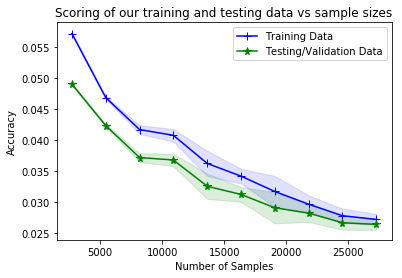

Code block 'learning_curve' took(HH:MM:SS): 0:00:17.071263
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.105509
Code block 'overalltime' took(HH:MM:SS): 0:00:20.933815
20933.814878950216


In [90]:
# timer = CodeTimer(name='overalltime')
# model_metrics = {}

# with timer:
#     for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):

#         pipeline = Pipeline([
#                 ('scaler', StandardScaler()),
#                 (model_name, model)
#         ])

#         cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 12)
#         result = runGridSearchAndPredict(pipeline, _x_train, _y_train, _x_test, _y_test, model_param_grid , cv = cv,score = 'f1_weighted')

#         _y_prediction = result['_y_prediction']

#         _matrix = confusion_matrix(y_true = _y_test ,y_pred = _y_prediction, labels = _y_test['y'].values)

#         model_metrics[model_name] = {}
#         model_metrics[model_name]['confusion_matrix'] = _matrix
#         model_metrics[model_name]['training_time'] = result['training_time']
#         model_metrics[model_name]['testing_time'] = result['testing_time']
#         model_metrics[model_name]['learning_curve_time'] = result['learning_curve_time']
# #         model_metrics[model_name]['accuracy_score'] = result['accuracy_score']
#         model_metrics[model_name]['f1_score'] = result['f1_score']
# #         model_metrics[model_name]['roc_auc_score'] = result['roc_auc_score']
# #         model_metrics[model_name]['roc_curve'] = result['roc_curve']
#         model_metrics[model_name]['best_estimator'] = result['best_estimator']
        
        
# print(timer.took)


In [41]:
folds = StratifiedKFold(n_splits =10, shuffle = True)
scaler = StandardScaler()
_x_train = scaler.fit_transform(_x_train)
_x_test = scaler.fit_transform(_x_test)
print(_y_test.shape,_y_train.shape)
import lightgbm as lgb

def evaluate_weighted_f1(preds, dtrain):  
    labels = dtrain.get_label()
#     print('somak dtrain ----', type(dtrain), labels.shape,labels)
#     print('somak----', type(preds), preds.shape)
    preds = preds.reshape(-1, 5)
#     print('somak1----', type(preds), preds.shape)
    preds = preds.argmax(axis = 1)
#     print('somak2----', type(preds), preds.shape)
    
    f_score = f1_score(labels,preds, average = 'weighted')
#     print('f1-',f_score)
    return 'f1_score', f_score, True
    # this follows the discussion in https://github.com/Microsoft/LightGBM/issues/1483
#     pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
#     f1 = f1_score(truth, np.round(predictions), average='weighted')
#     return ('weightedf1', f1, True) 

param = {
    
    'metric' :None,
    'num_class': 5,
        'num_leaves': 32,
    'class_weight' :'balanced',
         'min_data_in_leaf': 50, 
         'objective':'multiclass',
         'max_depth': 20,
         'learning_rate': 0.001,
         "min_child_samples": 15,
         "boosting": "gbdt",
         'n_estimators': 1000,
         'num_boost_round':10000,
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
# 'metric': ['multi_error'],
         "lambda_l1": 0.1,
         "verbosity": -1}

for fold_, (trn_idx, val_idx) in enumerate(folds.split(panda.DataFrame(_x_train).values,\
                                                       panda.DataFrame(_y_train).values)):
    print('----', trn_idx, val_idx)
    print("fold n°{}".format(fold_))
    
    x0,y0 = panda.DataFrame(_x_train).iloc[trn_idx], panda.DataFrame(_y_train).iloc[trn_idx]
    x1,y1 = panda.DataFrame(_x_train).iloc[val_idx], panda.DataFrame(_y_train).iloc[val_idx]
    
    trn_data = lgb.Dataset(x0, label= y0); val_data = lgb.Dataset(x1, label= y1)
    
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], 
                    verbose_eval=500, early_stopping_rounds = 150, feval = evaluate_weighted_f1)
#     clf.predict(x1, num_iteration=clf.best_iteration)

(12980, 1) (30286, 1)
---- [    0     1     2 ... 30283 30284 30285] [   10    13    21 ... 30260 30273 30274]
fold n°0
Training until validation scores don't improve for 150 rounds.
Early stopping, best iteration is:
[1]	training's multi_logloss: 1.60795	training's f1_score: 0.285258	valid_1's multi_logloss: 1.60797	valid_1's f1_score: 0.280987
---- [    0     1     2 ... 30283 30284 30285] [    7    12    24 ... 30261 30262 30276]
fold n°1
Training until validation scores don't improve for 150 rounds.
Early stopping, best iteration is:
[1]	training's multi_logloss: 1.60796	training's f1_score: 0.282619	valid_1's multi_logloss: 1.60796	valid_1's f1_score: 0.280972
---- [    0     1     2 ... 30283 30284 30285] [    6     9    11 ... 30242 30249 30280]
fold n°2
Training until validation scores don't improve for 150 rounds.
Early stopping, best iteration is:
[1]	training's multi_logloss: 1.60796	training's f1_score: 0.285604	valid_1's multi_logloss: 1.60796	valid_1's f1_score: 0.280303


#### There are some observations we can make: 

#### 1. DecisionTreeClassifier gives perfect predictions gives  best f1 score. And we have similar scores for testing and training data , suggesting less variations/overfitting


#### We will use both these classifiers to make a prediction on the train set

In [18]:
clf

#### At this point our models are ready using which we can predict on our test data. Note since we used  a pipeline, model has the built in scaling.

### Prepare the test data and run prediction


#### remember to check for column dimension

In [12]:
test_data = panda.read_csv(test_data_path)
test_data.shape

(18543, 66)

In [41]:
x.shape

(43266, 56)

In [42]:
test_data.head()

,Unnamed: 0,complaint_id,complaint_reason_x,complaint_reason_encoded,date_received,transaction_type,complaint_reason_y,company_response,date_sent_to_company,consumer_disputes,...,Company believes complaint is the result of an isolated error,Company believes complaint relates to a discontinued policy or procedure,Company believes complaint represents an opportunity for improvement to better serve consumers,Company believes it acted appropriately as authorized by contract or law,Company believes the complaint is the result of a misunderstanding,Company can't verify or dispute the facts in the complaint,Company chooses not to provide a public response,Company disputes the facts presented in the complaint,Company has responded to the consumer and the CFPB and chooses not to provide a public response,encoded_consumer_disputes
0,0,Te-1,"Account opening, closing, or management",5,8/18/2016,Bank account or service,"Account opening, closing, or management",Company has responded to the consumer and the ...,8/18/2016,No,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,1,Te-2,Communication tactics,24,4/18/2016,Debt collection,Communication tactics,Company believes it acted appropriately as aut...,4/20/2016,No,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,2,Te-3,Incorrect information on credit report,13,3/23/2016,Credit reporting,Incorrect information on credit report,Company has responded to the consumer and the ...,3/23/2016,No,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,3,Te-4,Dealing with your lender or servicer,4,6/26/2017,Student loan,Dealing with your lender or servicer,Company has responded to the consumer and the ...,6/26/2017,No,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,4,Te-5,Incorrect information on credit report,13,5/13/2016,Credit reporting,Incorrect information on credit report,Company has responded to the consumer and the ...,5/13/2016,No,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


In [13]:
test_x = test_data[[i for i in test_data.columns.tolist() if i not in columns_not_required]]

In [14]:
test_x.shape, x.shape

((18543, 56), (43266, 56))

In [24]:
set(x.columns.tolist()) - set(test_x.columns.tolist())

set()

In [42]:
# y_predict = clf.predict(scaler.fit_transform(test_x))
y_predict = clf.predict(scaler.fit_transform(test_x), num_iteration=clf.best_iteration)

In [43]:
# np.bincount(y_predict)
y_predict_1 = y_predict.argmax(axis=1)
np.bincount(y_predict_1)

array([18444,     0,    99], dtype=int64)

In [44]:
submission_data = panda.read_csv(sample_submission_path)

submission_data.head()

,Complaint-ID,Complaint-Status
0,Te-1,Closed with explanation
1,Te-2,Closed with explanation
2,Te-3,Closed with explanation
3,Te-4,Closed with explanation
4,Te-5,Closed with explanation


In [45]:
#lets apply encoding on our target columns

target_dict = {
    
    'Closed with explanation':0,
    'Closed with non-monetary relief':1,
    'Closed with monetary relief':2,
    'Closed':3,
    'Untimely response':4
    
}


target_dict_reverse = {
    
    0:'Closed with explanation',
    1:'Closed with non-monetary relief',
    2:'Closed with monetary relief',
    3:'Closed',
    4:'Untimely response'
    
}
predict = panda.DataFrame({'y':y_predict_1})
predict.head(45)

,y
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [46]:
predict['Complaint-Status'] = predict.y.apply(lambda x:target_dict_reverse.get(x))

In [47]:
predict.head()

,y,Complaint-Status
0,0,Closed with explanation
1,0,Closed with explanation
2,0,Closed with explanation
3,0,Closed with explanation
4,0,Closed with explanation


In [48]:
predict['Complaint-ID'] = test_data['complaint_id']

predict.drop(['y'], axis=1, inplace=True)
predict.head(25)

,Complaint-Status,Complaint-ID
0,Closed with explanation,Te-1
1,Closed with explanation,Te-2
2,Closed with explanation,Te-3
3,Closed with explanation,Te-4
4,Closed with explanation,Te-5
5,Closed with explanation,Te-6
6,Closed with explanation,Te-7
7,Closed with explanation,Te-8
8,Closed with explanation,Te-9
9,Closed with explanation,Te-10


In [49]:
predict[['Complaint-ID','Complaint-Status']].to_csv('dataset/submission_round10_2.csv', index=False)